# Powder diffraction with spotty data ... how to handle the spottiness.

The data used for this tutorial are available on `http://www.silx.org/pub/pyFAI/pyFAI_UM_2026/spotty/`, it is a standard material SRM640, Silicon, recorded on the ID11 beamline with a sub-micron beam at 40 keV, using an Eiger2 CdTe detector at 200Hz. The Eiger file is the first data-file from a dataset containing 90 of them.


In [1]:
%matplotlib inline

In [2]:
import copy
import os
import glob
import time
import numpy
from matplotlib.pyplot import subplots
import fabio
from silx.resources import ExternalResources
import pyFAI
from pyFAI.gui import jupyter

start_time = time.perf_counter()
print(f"Using pyFAI version {pyFAI.version}")

Using pyFAI version 2026.1.0-dev0


In [3]:
resource = ExternalResources("spotty", "http://www.silx.org/pub/pyFAI/pyFAI_UM_2026/spotty/")

## Display the first and the average frame

In [4]:
fimg = fabio.open(resource.getfile("eiger_0000.h5"))
frame0 = fimg.data
fimg.nframes

200

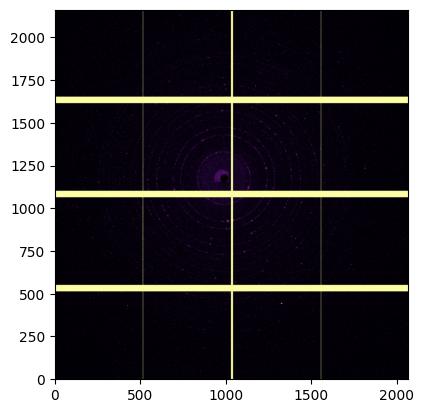

In [5]:
# display the image:
jupyter.display(frame0);

In [6]:
%%time 
# Average the dataset:
num = numpy.zeros(frame0.shape, dtype=numpy.int64)  # Contains the sum of all signal
den = numpy.zeros(frame0.shape, dtype=numpy.int64)  # Contains the number of contributing pixels
for frame in fimg:
    num +=  numpy.where(frame.data<65535, frame.data, 0)
    den +=  numpy.where(frame.data<65535, 1, 0)
avg = numpy.zeros(frame0.shape, dtype=numpy.float64)
numpy.divide(num, den, where=den!=0, out=avg);

CPU times: user 4.95 s, sys: 692 ms, total: 5.64 s
Wall time: 5.66 s


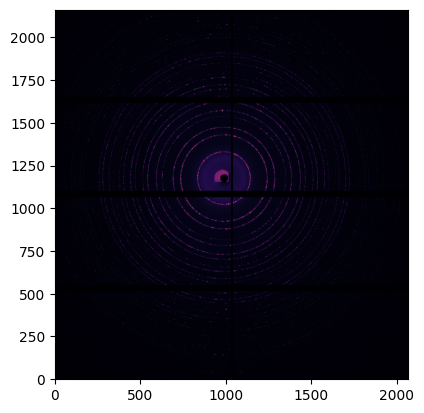

In [7]:
jupyter.display(avg);

## Perform the azimuthal integration and compare with sigma-clipping and median filtering

First on needs to load the azimuthal integrator.

In [8]:
ai = pyFAI.load(resource.getfile("ID11_40keV.poni"))
ai

Detector Eiger2 CdTe 4M	 PixelSize= 75µm, 75µm	 BottomRight (3)	 CdTe,750µm
Wavelength= 0.305501 Å	Parallax: off
SampleDetDist= 1.178702e-01 m	PONI= 8.783056e-02, 7.342441e-02 m	rot1=-0.005004  rot2=0.001866  rot3=0.000000 rad
DirectBeamDist= 117.872 mm	Center: x=986.856, y=1174.007 pix	Tilt= 0.306° tiltPlanRotation= 20.455° λ= 0.306Å

In [9]:
# Common integration parameters:
kwargs = {"npt": 2000, 
          "unit": "2th_deg", 
          "method": ("no", "csr", "cython"),
          "dummy": 65535,
         }

In [10]:
res_aver = ai.integrate1d(avg, **kwargs)
res_sigma = ai.sigma_clip_ng(avg, **kwargs, error_model="azimuthal")
res_median = ai.medfilt1d_ng(avg, **kwargs)

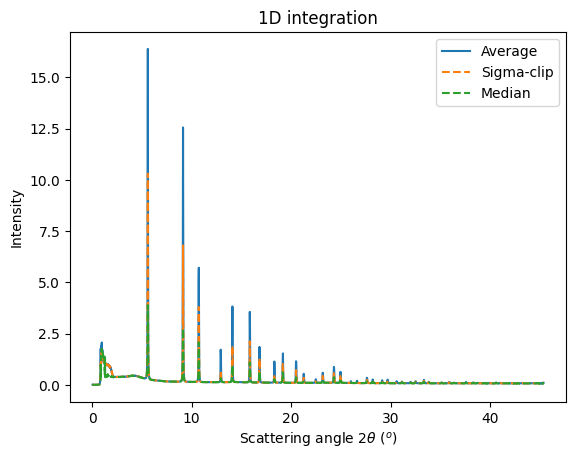

In [11]:
ax = jupyter.plot1d(res_aver, label="Average")
ax.plot(*res_sigma[:2], "--" ,label="Sigma-clip")
ax.plot(*res_median[:2], "--" ,label="Median")
ax.legend();

## Calculate the spottiness for the first and the average frame:

In [12]:
kwargs["error_model"] = "azimuthal"
res_avg = ai.integrate1d(avg,    **kwargs)
res_fr0 = ai.integrate1d(frame0, **kwargs)
res_avg.calc_spottiness()

0.025335838760482423

In [13]:
print(f"Unweighted spottiness index: S(frame0)={res_fr0.calc_spottiness():.3f};\tS(avg)={res_avg.calc_spottiness():.3f}.")
print(f"I-Weighted spottiness index: S(frame0)={res_fr0.calc_spottiness(True):.3f};\tS(avg)={res_avg.calc_spottiness(True):.3f}.")

Unweighted spottiness index: S(frame0)=0.156;	S(avg)=0.025.
I-Weighted spottiness index: S(frame0)=0.209;	S(avg)=0.061.


## Integrate all stack and plot spottiness for each frame in the stack

In [14]:
%%time
res = [ai.integrate1d(frame.data, **kwargs) for frame in fimg]

CPU times: user 2min 57s, sys: 206 ms, total: 2min 57s
Wall time: 8.01 s


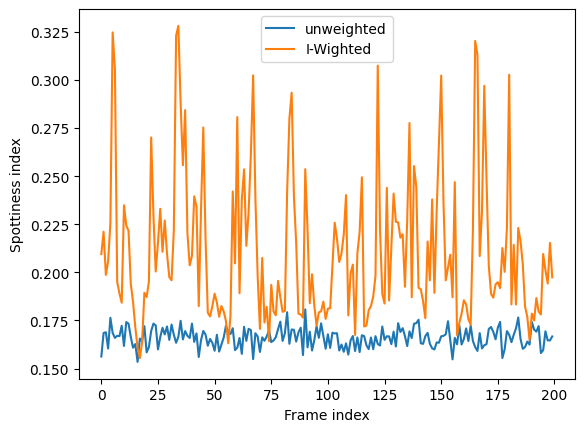

In [15]:
fig,ax = subplots()
ax.plot([r.calc_spottiness() for r in res], label="unweighted")
ax.plot([r.calc_spottiness(weighted=True) for r in res], label="I-Wighted")
ax.set_xlabel("Frame index")
ax.set_ylabel("Spottiness index")
ax.legend();

## Accumulate frames to assess the evolution of spottiness with the number of frames

This should evolve as $1/\sqrt{N}$

In [16]:
# Accumulate 2 frames:
print("First", res[0].calc_spottiness())
print("Second", res[1].calc_spottiness())
print("1 + 2", res[1].union(res[0]).calc_spottiness())

First 0.15621348906463955
Second 0.16844202699901842
1 + 2 0.14151299563643194


In [17]:
%%time
tmp = copy.deepcopy(res[0])
acc_u = [res[0].calc_spottiness()]
acc_w = [res[0].calc_spottiness(True)]
for i in res[1:]:
    tmp = i.union(tmp)
    acc_u.append(tmp.calc_spottiness())
    acc_w.append(tmp.calc_spottiness(True))

CPU times: user 89.8 ms, sys: 0 ns, total: 89.8 ms
Wall time: 89.8 ms


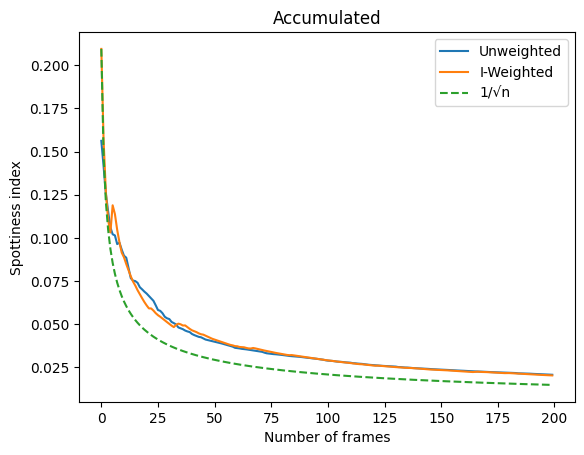

In [18]:
fig,ax = subplots()
ax.plot(acc_u, label="Unweighted")
ax.plot(acc_w, label="I-Weighted")
ax.plot(acc_w[0]/numpy.sqrt(1+numpy.arange(fimg.nframes)), "--", label="1/√n")
ax.set_ylabel("Spottiness index")
ax.set_xlabel("Number of frames")
ax.set_title("Accumulated")
ax.legend();

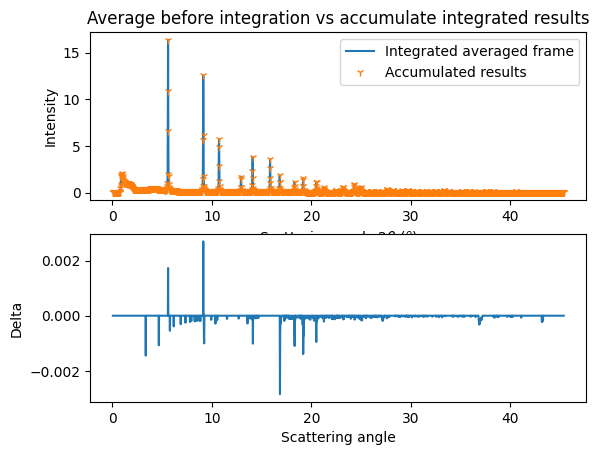

In [19]:
fig,ax = subplots(2)
jupyter.plot1d(res_aver, label="Integrated averaged frame", ax=ax[0])
ax[0].plot(tmp.radial,tmp.intensity,"1", label="Accumulated results")
ax[0].set_title("Average before integration vs accumulate integrated results")
ax[0].legend()
ax[1].plot(tmp.radial,res_aver.intensity - tmp.intensity, label="delta")
ax[1].set_xlabel("Scattering angle")
ax[1].set_ylabel("Delta");
# ax[1].legend();

## Conclusions:
* Merging data, especially when they come from a Dectris detector, requires careful handling of the dynamically masked pixels
* Azimuthal integration and frame averaging can be interchanged, but only under certain conditions 
* It is possible to separate Bragg spots from powder signal using sigma-clipping or median filtering in azimuthal space
* The spottiness of the integrated pattern can be measured if the "azimuthal" error model was used.
* Residual spottiness evolves as $1/\sqrt{N}$

In [20]:
print(f"Run-time: {time.perf_counter()-start_time:.3f}s")

Run-time: 20.163s
